## Feature Selection and Modeling using Lasso

Okay, now it's time to model! We've done exploratory data analysis, we've cleaned, engineered, and removed collinear features. Let's select our features for our model!

*Note: I am testing Linear Regression, Ridge, and LASSO models, and I will **reselect my features** for Ridge Regression, so the features you see here may not be the ones that are used in those models*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [2]:
houses_train_clean = pd.read_csv('../datasets/cleaned/houses_train_clean.csv')
houses_test_clean = pd.read_csv('../datasets/cleaned/houses_test_clean.csv')

In [3]:
# random_feature_thresh_test(houses_train_clean, 'SalePrice', features_all, 1.5)

In [4]:
# # mean_corr = houses_train_clean.corr()['SalePrice'].mean()
features = get_features(houses_train_clean, 0) # I want as many features as possible for LassoCV, so I'm passing a threshold of 0
len(features)


288

In [5]:
X_real_test = houses_test_clean[[col for col in features if col in houses_test_clean]]
X_real_test.shape

(878, 258)

## Prepping model for Kaggle Submission

In [6]:
# # Garage Cars was type int64 in houses_test_clean, was type float in houses_train_clean_pol_scale
# houses_test_clean['Garage Cars'] = houses_test_clean['Garage Cars'].apply(lambda x: float(x))

In [7]:
houses_test_clean.shape

(878, 311)

## Testing!!

### Selecting X and Y

In [8]:
outlier_indices = [125, 1769] # These indices were throwing off my model drastically
X = houses_train_clean[[col for col in features if col in houses_test_clean]].drop(outlier_indices)
y = houses_train_clean['SalePrice'].drop(outlier_indices)

In [9]:
# Establishing OLS model to be able to select P-Values
model = sm.OLS(y, X).fit()

In [10]:
# Selecting features by p-value. Intentionally trying to overfit this model to let LassoCV do its work
significant_features = list(model.pvalues[model.pvalues < .05].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [11]:
X = houses_train_clean[[col for col in significant_features if col in houses_test_clean]].drop(outlier_indices)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=342)

In [13]:
# Scaling my data for LASSO
sc = StandardScaler()

In [14]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Training model on all data

In [15]:
lr = LinearRegression()

In [16]:
lr.fit(X, y)

LinearRegression()

In [17]:
X_real_test = houses_test_clean[[col for col in significant_features if col in houses_test_clean]]
X_real_test.shape

(878, 79)

In [18]:
X_real_test_sc = sc.fit_transform(X_real_test)

In [19]:
len(X_real_test)

878

## Let the tests begin!

In [20]:
# From Lesson 4.02 on Logistic Regression! Thanks Adi Brohnstein

l_alphas = np.logspace(0, 5, 2000)
# Cross-validate over our list of lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train);

In [21]:
y_pred = lasso_cv.predict(X_test_sc)

In [22]:
lasso_cv.score(X_test_sc, y_test)

0.9480643149600543

In [23]:
print(f'The MSE is {metrics.mean_squared_error(y_test, y_pred, squared=False)}')

The MSE is 18074.756647976996


In [24]:
# Baseline Model
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
print(f'The Baseline RMSE is {metrics.mean_squared_error(y_test, null_pred, squared=False)}')

The Baseline RMSE is 79312.11414948582


## The Model is drastically outperforming the Baseline!

In [25]:
resids = y_test - y_pred

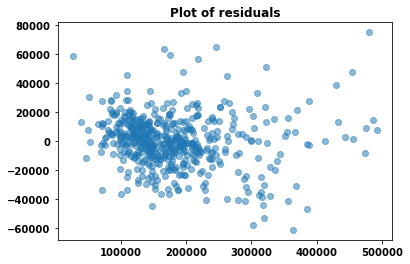

In [26]:
plt.scatter(y_pred, resids, alpha=0.5)
plt.title('Plot of residuals');

This residual plot looks similar to the others, still not doing a great job predicting homes over 220k

In [27]:
houses_test_clean['SalePrice'] = lasso_cv.predict(X_real_test_sc)

submission = houses_test_clean[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,181647.132986
std,850.838263,76028.614671
min,2.000000,22521.267785
25%,692.250000,132563.451225
50%,1433.000000,163201.847124
75%,2197.500000,215514.795734
max,2928.000000,657008.169550


In [28]:
submission.to_csv('../submissions/test66_lasso.csv', index=False)

In [29]:
pd.DataFrame(lasso_cv.coef_, X_real_test.columns).rename(columns={0 : 'Coefficients'}).to_csv('../datasets/coefs/lasso_coefs.csv')